<a href="https://colab.research.google.com/github/Tham2106/test/blob/main/final_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **EfficientNet-B0 + ArcFace**

**Dataset & DataLoader**

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom Dataset từ fer2013.csv
class FER2013Custom(Dataset):
    def __init__(self, csv_file, usage, transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data['Usage'] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.loc[idx, 'pixels']
        label = int(self.data.loc[idx, 'emotion'])
        image = np.array([int(p) for p in pixels.split()], dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image.convert("RGB"))
        return image, label

# Transform
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Tạo dataset
csv_path = '/content/drive/MyDrive/fer2013.csv'

train_dataset = FER2013Custom(csv_path, usage='Training', transform=train_transforms)
val_dataset = FER2013Custom(csv_path, usage='PublicTest', transform=val_transforms)
test_dataset = FER2013Custom(csv_path, usage='PrivateTest', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)


In [ ]:
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 28709
Val size: 3589
Test size: 3589


Số mẫu trong tập huấn luyện: 28709
Số mẫu trong tập validation: 3589
Số mẫu trong tập test: 3589


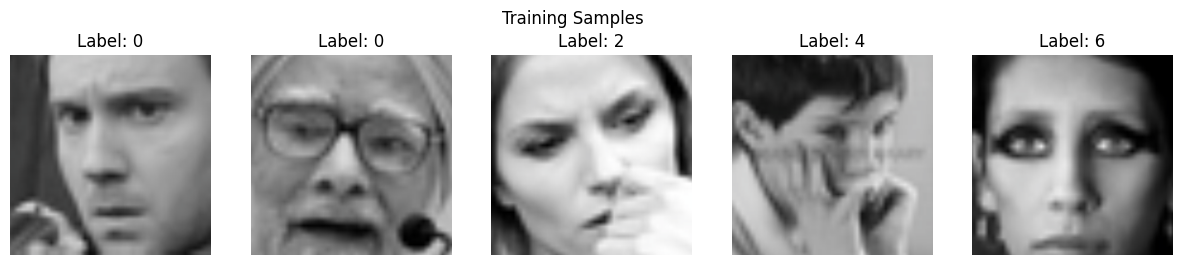

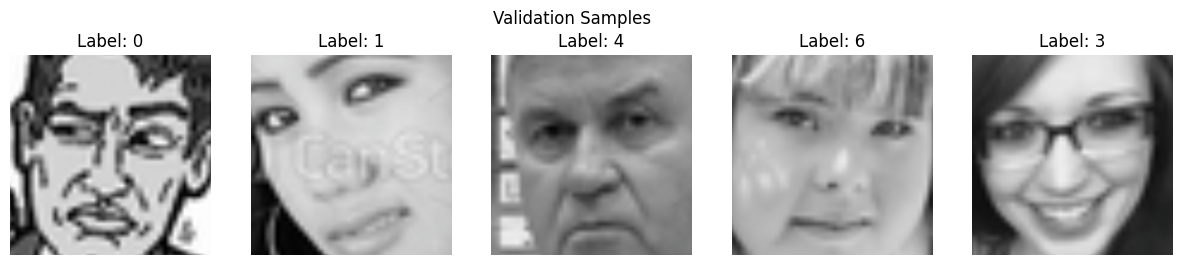

In [ ]:
import matplotlib.pyplot as plt

# In số lượng mẫu mỗi tập
print("Số mẫu trong tập huấn luyện:", len(train_dataset))
print("Số mẫu trong tập validation:", len(val_dataset))
print("Số mẫu trong tập test:", len(test_dataset))

# Hiển thị một vài ảnh mẫu và nhãn
def show_samples(dataset, title=""):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # đổi từ [C,H,W] sang [H,W,C]
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # unnormalize
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Gọi hàm hiển thị
show_samples(train_dataset, title="Training Samples")
show_samples(val_dataset, title="Validation Samples")



In [ ]:
# Lấy 1 batch thử
images, labels = next(iter(train_loader))
print("Kích thước ảnh:", images.shape)  # [batch_size, 3, 224, 224]
print("Label batch:", labels[:10])      # In 10 label đầu tiên

Kích thước ảnh: torch.Size([64, 3, 224, 224])
Label batch: tensor([3, 6, 2, 3, 6, 3, 0, 6, 3, 2])


**Mô hình EfficientNet + ArcFace**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import math

# ArcFace Layer
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, labels):
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - cosine**2 + 1e-6)
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# EfficientNet-B0 + ArcFace
class FER_EfficientNet_ArcFace(nn.Module):
    def __init__(self, num_classes=7, embed_dim=512):
        super().__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.backbone.classifier = nn.Identity()  # Bỏ classifier gốc

        self.embedding = nn.Linear(1280, embed_dim)  # EfficientNet-B0 output là 1280
        self.arc_margin = ArcMarginProduct(embed_dim, num_classes)

    def forward(self, x, labels=None):
        features = self.backbone(x)
        features = self.embedding(features)

        if labels is not None:
            logits = self.arc_margin(features, labels)
        else:
            # inference mode
            logits = F.linear(F.normalize(features), F.normalize(self.arc_margin.weight)) * self.arc_margin.s
        return logits


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = FER_EfficientNet_ArcFace().to(device)

# Kiểm tra 1 batch
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images, labels)
print("Output logits shape:", outputs.shape)  # [batch_size, 7]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 154MB/s]


Output logits shape: torch.Size([64, 7])


In [ ]:
# Kiểm tra thử 1 batch
model.eval()
images, labels = next(iter(train_loader))
images = images.to(device)
try:
    outputs = model(images)
    print("Model test pass.")
except Exception as e:
    print("Model test failed:", e)


Model test pass.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np

# ==== Tính class weights (không bỏ lớp nào) ====
def compute_class_weights(labels, num_classes):
    counts = Counter(labels)
    total = sum(counts.values())
    weights = [total / (num_classes * counts.get(i, 1)) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float32)

# ==== Tạo sampler để oversample lớp hiếm ====
def get_sampler(labels):
    class_count = Counter(labels)
    class_weights = {cls: 1.0 / count for cls, count in class_count.items()}
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(labels), replacement=True)
    return sampler

In [ ]:
for i in range(len(train_dataset)):
    try:
        _ = train_dataset[i]
    except Exception as e:
        print(f"Lỗi tại sample {i}: {e}")

In [ ]:
for i in range(len(train_dataset)):
    try:
        image, label = train_dataset[i]
    except Exception as e:
        print(f"Lỗi tại index {i}: {e}")
        break

In [ ]:
# ==== Lấy toàn bộ nhãn trong train_dataset (dùng index chuẩn) ====
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]  # đảm bảo không lỗi index

In [ ]:
# ==== Chuẩn bị dữ liệu + DataLoader ====
num_classes = 7
class_weights = compute_class_weights(train_labels, num_classes).to(device)
sampler = get_sampler(train_labels)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ==== Loss, Optimizer, Scheduler ====
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# ==== Hàm đánh giá ====
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total if total > 0 else 0

# ==== Training loop ====
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    val_acc = evaluate(model, val_loader)
    avg_loss = running_loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%",)


Epoch 1/50 - Loss: 7.4416, Val Acc: 39.82%
Epoch 2/50 - Loss: 4.8295, Val Acc: 47.51%
Epoch 3/50 - Loss: 3.3660, Val Acc: 37.92%
Epoch 4/50 - Loss: 2.6224, Val Acc: 43.35%
Epoch 5/50 - Loss: 2.7501, Val Acc: 43.05%
Epoch 6/50 - Loss: 2.7831, Val Acc: 45.03%
Epoch 7/50 - Loss: 2.7065, Val Acc: 45.92%
Epoch 8/50 - Loss: 2.7088, Val Acc: 48.09%
Epoch 9/50 - Loss: 2.6630, Val Acc: 50.38%
Epoch 10/50 - Loss: 2.6692, Val Acc: 51.57%
Epoch 11/50 - Loss: 2.6322, Val Acc: 52.08%
Epoch 12/50 - Loss: 2.6985, Val Acc: 52.47%
Epoch 13/50 - Loss: 2.5781, Val Acc: 52.30%
Epoch 14/50 - Loss: 2.6096, Val Acc: 52.52%
Epoch 15/50 - Loss: 2.5510, Val Acc: 53.25%
Epoch 16/50 - Loss: 2.5476, Val Acc: 52.33%
Epoch 17/50 - Loss: 2.5297, Val Acc: 54.69%
Epoch 18/50 - Loss: 2.5094, Val Acc: 54.67%
Epoch 19/50 - Loss: 2.4593, Val Acc: 54.86%
Epoch 20/50 - Loss: 2.4564, Val Acc: 56.00%
Epoch 21/50 - Loss: 2.4566, Val Acc: 56.48%
Epoch 22/50 - Loss: 2.4750, Val Acc: 55.78%
Epoch 23/50 - Loss: 2.4429, Val Acc: 55.6

In [ ]:
# Add this function definition before the call to evaluate
def evaluate(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad(): # Disable gradient calculation
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Rest of the code where evaluate is called remains the same
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 60.10%


In [ ]:
# --- Lưu trọng số mô hình ---
import torch
save_path = "fer_effnet_arcface.pth"
torch.save(model.state_dict(), save_path)
print(f"Đã lưu mô hình tại: {save_path}")


Đã lưu mô hình tại: fer_effnet_arcface.pth


In [ ]:
# --- Load lại model để kiểm tra ---
model_loaded = FER_EfficientNet_ArcFace().to(device)
model_loaded.load_state_dict(torch.load(save_path))
model_loaded.eval()

# Kiểm tra nhanh:
test_acc = evaluate(model_loaded, test_loader)
print(f"Độ chính xác khi load lại mô hình: {test_acc:.2f}%")

Độ chính xác khi load lại mô hình: 60.10%


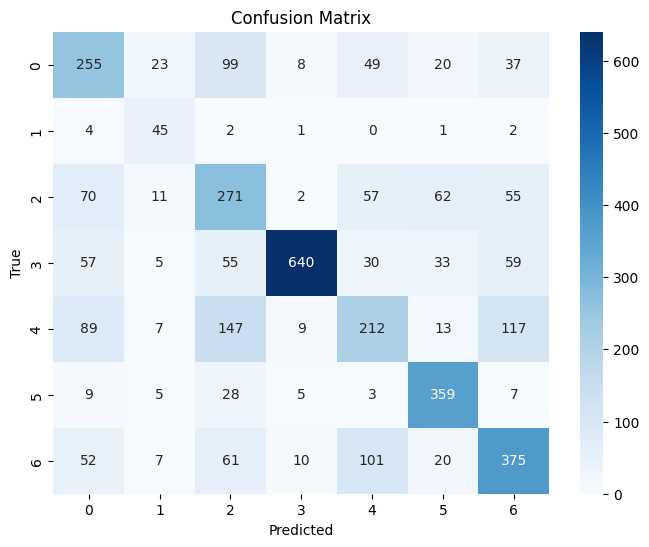

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Hàm lấy toàn bộ dự đoán và nhãn thật ---
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

# --- Lấy dự đoán ---
preds, labels = get_predictions(model, test_loader)

# --- Confusion matrix ---
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- F1, Precision, Recall ---



In [ ]:
print(classification_report(labels, preds, digits=4))

              precision    recall  f1-score   support

           0     0.4757    0.5193    0.4966       491
           1     0.4369    0.8182    0.5696        55
           2     0.4087    0.5133    0.4551       528
           3     0.9481    0.7281    0.8237       879
           4     0.4690    0.3569    0.4054       594
           5     0.7067    0.8630    0.7771       416
           6     0.5752    0.5990    0.5869       626

    accuracy                         0.6010      3589
   macro avg     0.5743    0.6283    0.5877      3589
weighted avg     0.6240    0.6010    0.6049      3589



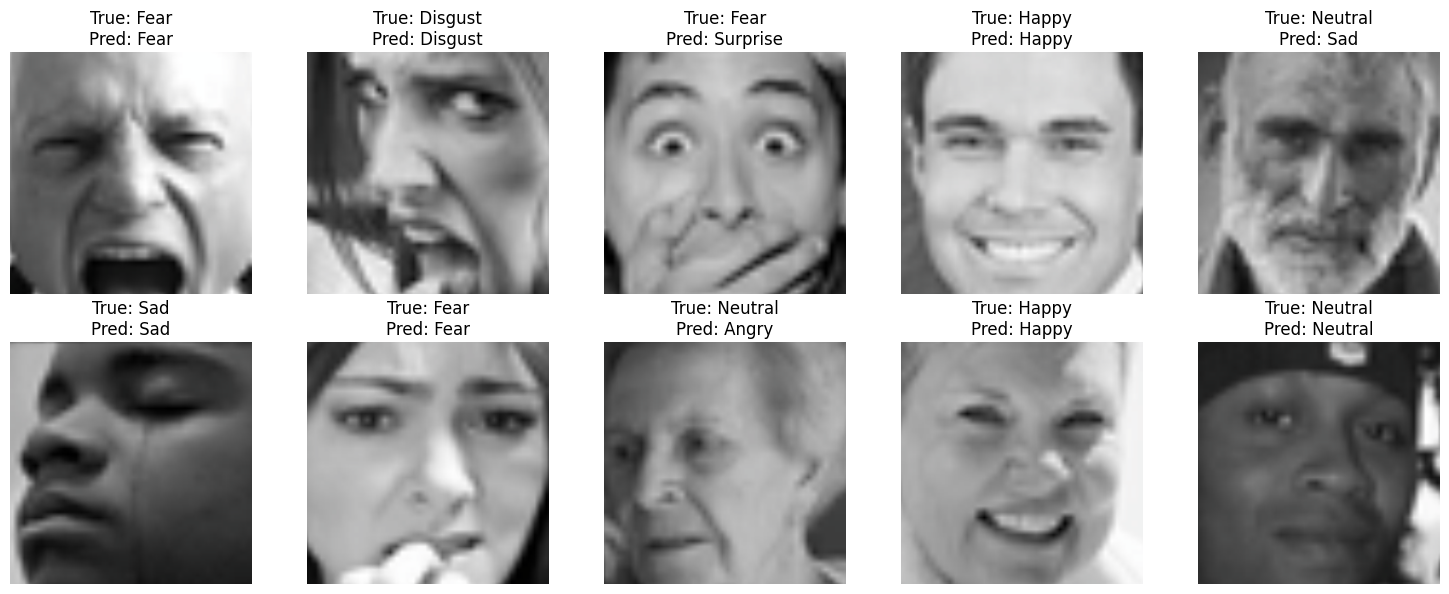

In [ ]:
# import random
# import numpy as np

# emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# def show_predictions(model, dataset, transform):
#     model.eval()
#     indices = random.sample(range(len(dataset)), 10)
#     plt.figure(figsize=(15, 6))

#     for i, idx in enumerate(indices):
#         img, label = dataset[idx]
#         input_img = transform(img).unsqueeze(0).to(device)
#         with torch.no_grad():
#             logits = model(input_img)
#             pred = torch.argmax(logits, dim=1).item()

#         plt.subplot(2, 5, i+1)
#         plt.imshow(img)
#         plt.title(f"True: {emotion_labels[label]}\nPred: {emotion_labels[pred]}")
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Gọi hàm
# show_predictions(model, test_dataset, val_transforms)

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Remove the 'transform' argument as it's not needed here
def show_predictions(model, dataset):
    model.eval()
    indices = random.sample(range(len(dataset)), 10)
    plt.figure(figsize=(15, 6))

    # Define un-normalization parameters (same as used in data transformation)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i, idx in enumerate(indices):
        # Get the already transformed image (tensor) and label
        # The image is already a tensor after being processed by val_transforms
        input_tensor, label = dataset[idx] # input_tensor is already on CPU

        # Add batch dimension and move to device for model inference
        input_tensor_cuda = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(input_tensor_cuda)
            pred = torch.argmax(logits, dim=1).item()

        plt.subplot(2, 5, i+1)

        # Convert the tensor back to a displayable format (NumPy array H, W, C)
        # Permute from [C, H, W] to [H, W, C]
        img_display = input_tensor.permute(1, 2, 0).numpy()

        # Un-normalize the image for display
        img_display = std * img_display + mean

        # Clip values to be in [0, 1] in case of floating point errors
        img_display = np.clip(img_display, 0, 1)

        plt.imshow(img_display)
        plt.title(f"True: {emotion_labels[label]}\nPred: {emotion_labels[pred]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Gọi hàm (không truyền val_transforms nữa)
show_predictions(model, test_dataset)

In [ ]:
def predict_image(image_path, model):
    img = Image.open(image_path).convert("RGB")
    input_tensor = val_transforms(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        pred = torch.argmax(logits, dim=1).item()

    plt.imshow(img)
    plt.title(f"Predicted: {emotion_labels[pred]}")
    plt.axis('off')
    plt.show()
    return emotion_labels[pred]

# Ví dụ dùng:
predict_image("/content/drive/MyDrive/Bài tập lớn/testanh/bngo.jpg", model)
predict_image("/content/drive/MyDrive/Bài tập lớn/testanh/hihi.jpg", model)
predict_image("/content/drive/MyDrive/Bài tập lớn/testanh/huhu.png", model)